In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight


In [6]:
dataset_dir = r"C:\Users\LATHA M\OneDrive\Desktop\Animal Classification\dataset"  # single dataset folder (with subfolders per class)

img_size = (224, 224)
batch_size = 32
epochs_stage1 = 10
epochs_stage2 = 20

In [8]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# First load everything
full_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

# Extract filepaths and labels
filepaths = full_data.filepaths
labels = full_data.classes
class_labels = list(full_data.class_indices.keys())

# Split into train/val/test (70% / 20% / 10%)
X_train, X_temp, y_train, y_temp = train_test_split(filepaths, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Found 1944 images belonging to 15 classes.
Train: 1360, Validation: 391, Test: 193


In [10]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest"
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

def make_gen(filepaths, labels, gen):
    df = pd.DataFrame({"filename": filepaths, "class": [class_labels[i] for i in labels]})
    return gen.flow_from_dataframe(
        dataframe=df,
        x_col="filename",
        y_col="class",
        target_size=img_size,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=True
    )

train_data = make_gen(X_train, y_train, train_gen)
val_data = make_gen(X_val, y_val, val_gen)
test_data = make_gen(X_test, y_test, test_gen)

num_classes = len(class_labels)

Found 1360 validated image filenames belonging to 15 classes.
Found 391 validated image filenames belonging to 15 classes.
Found 193 validated image filenames belonging to 15 classes.


In [12]:
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [14]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
preds = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("ultimate_model.h5", monitor="val_accuracy", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

In [16]:
model.fit(train_data, validation_data=val_data, epochs=epochs_stage1, class_weight=class_weights_dict, callbacks=callbacks)

C:\Users\LATHA M\Desktop\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0877 - loss: 3.0592

43/43 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.1118 - loss: 2.8512 - val_accuracy: 0.3171 - val_loss: 2.3247 - learning_rate: 1.0000e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2546 - loss: 2.3465

43/43 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.2860 - loss: 2.2790 - val_accuracy: 0.5985 - val_loss: 1.9064 - learning_rate: 1.0000e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3750 - loss: 2.0361

43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.4074 - loss: 1.9586 - val_accuracy: 0.7187 - val_loss: 1.5371 - learning_rate: 1.0000e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5052 - loss: 1.7118

43/43 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.5265 - loss: 1.6510 - val_accuracy: 0.8133 - val_loss: 1.2153 - learning_rate: 1.0000e-04
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5928 - loss: 1.4351

43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.6125 - loss: 1.3858 - val_accuracy: 0.8619 - val_loss: 0.9618 - learning_rate: 1.0000e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6612 - loss: 1.2094

43/43 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6640 - loss: 1.2077 - val_accuracy: 0.8900 - val_loss: 0.7969 - learning_rate: 1.0000e-04
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6884 - loss: 1.1427

43/43 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6934 - loss: 1.0802 - val_accuracy: 0.9156 - val_loss: 0.6760 - learning_rate: 1.0000e-04
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7381 - loss: 0.9817

43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7368 - loss: 0.9562 - val_accuracy: 0.9284 - val_loss: 0.5791 - learning_rate: 1.0000e-04
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7457 - loss: 0.9256

43/43 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7581 - loss: 0.8843 - val_accuracy: 0.9335 - val_loss: 0.5192 - learning_rate: 1.0000e-04
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7818 - loss: 0.7985

43/43 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7757 - loss: 0.8032 - val_accuracy: 0.9386 - val_loss: 0.4687 - learning_rate: 1.0000e-04


In [18]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(train_data, validation_data=val_data, epochs=epochs_stage2, class_weight=class_weights_dict, callbacks=callbacks)


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6673 - loss: 1.1587

43/43 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6809 - loss: 1.1212 - val_accuracy: 0.9412 - val_loss: 0.4164 - learning_rate: 1.0000e-05
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6875 - loss: 1.0433

43/43 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7059 - loss: 1.0010 - val_accuracy: 0.9463 - val_loss: 0.3756 - learning_rate: 1.0000e-05
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7610 - loss: 0.8692 - val_accuracy: 0.9437 - val_loss: 0.3420 - learning_rate: 1.0000e-05
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8066 - loss: 0.7612 - val_accuracy: 0.9437 - val_loss: 0.3150 - learning_rate: 1.0000e-05
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7985 - loss: 0.7040 - val_accuracy: 0.9437 - val_loss: 0.2938 - learning_rate: 1.0000e-05
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8089 - loss: 0.7192

43/43 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8228 - loss: 0.6837 - val_accuracy: 0.9488 - val_loss: 0.2769 - learning_rate: 1.0000e-05
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8487 - loss: 0.5967

43/43 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8404 - loss: 0.6049 - val_accuracy: 0.9540 - val_loss: 0.2599 - learning_rate: 1.0000e-05
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8192 - loss: 0.5811

43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8257 - loss: 0.5807 - val_accuracy: 0.9591 - val_loss: 0.2437 - learning_rate: 1.0000e-05
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8625 - loss: 0.5279 - val_accuracy: 0.9565 - val_loss: 0.2303 - learning_rate: 1.0000e-05
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.8574 - loss: 0.5108 - val_accuracy: 0.9591 - val_loss: 0.2180 - learning_rate: 1.0000e-05
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8816 - loss: 0.4564 - val_accuracy: 0.9591 - val_loss: 0.2077 - learning_rate: 1.0000e-05
Epoch 12/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8853 - loss: 0.4523 - val_accuracy: 0.9591 - val_loss: 0.1954 - learning_rate: 1.0000e-05
Epoch 13/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8809 - loss: 0.4121 - val_accuracy: 0.9591 - val_loss: 0.1862 - learning_rate: 1.0000e-05
Epoch 14/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8690 - loss: 0.419

43/43 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8728 - loss: 0.4211 - val_accuracy: 0.9693 - val_loss: 0.1780 - learning_rate: 1.0000e-05
Epoch 15/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9051 - loss: 0.3695 - val_accuracy: 0.9642 - val_loss: 0.1710 - learning_rate: 1.0000e-05
Epoch 16/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9000 - loss: 0.3639 - val_accuracy: 0.9642 - val_loss: 0.1632 - learning_rate: 1.0000e-05
Epoch 17/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.9074 - loss: 0.3454 - val_accuracy: 0.9668 - val_loss: 0.1556 - learning_rate: 1.0000e-05
Epoch 18/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9228 - loss: 0.2984 - val_accuracy: 0.9668 - val_loss: 0.1489 - learning_rate: 1.0000e-05
Epoch 19/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9103 - loss: 0.3352 - val_accuracy: 0.9668 - val_loss: 0.1426 - learning_rate: 1.0000e-05
Epoch 20/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9074 - loss: 

In [20]:
test_loss, test_acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 904ms/step - accuracy: 0.9430 - loss: 0.1658
✅ Test Accuracy: 94.30%


In [22]:
pred_probs = model.predict(test_data, verbose=1)
pred_indices = np.argmax(pred_probs, axis=1)
confidences = np.max(pred_probs, axis=1) * 100
results = pd.DataFrame({
    "Image": [os.path.basename(f) for f in X_test],
    "True Class": [class_labels[i] for i in y_test],
    "Predicted Class": [class_labels[i] for i in pred_indices],
    "Confidence": confidences
})
results.to_csv("batch_predictions.csv", index=False)
print("✅ Predictions saved to 'batch_predictions.csv'")

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 
✅ Predictions saved to 'batch_predictions.csv'


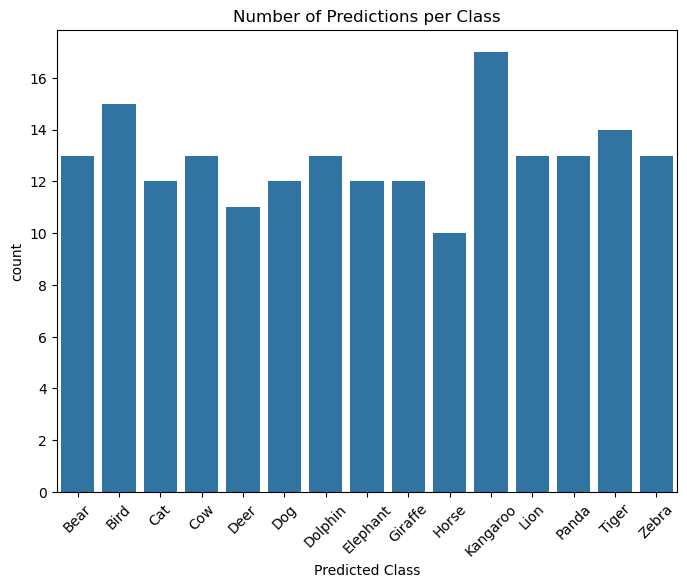

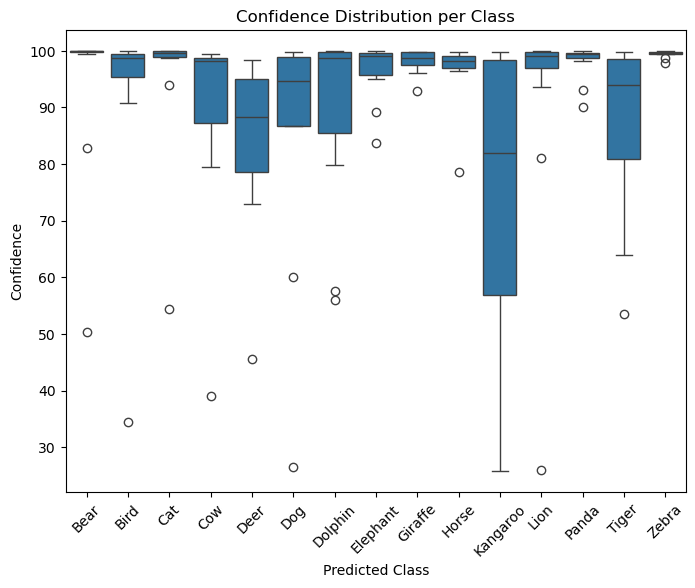

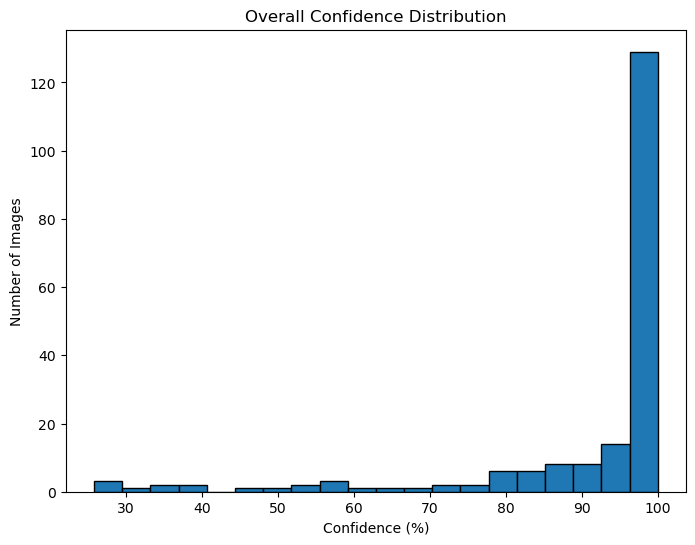

In [24]:
plt.figure(figsize=(8,6))
sns.countplot(x="Predicted Class", data=results, order=class_labels)
plt.title("Number of Predictions per Class")
plt.xticks(rotation=45)
plt.show()

# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x="Predicted Class", y="Confidence", data=results, order=class_labels)
plt.title("Confidence Distribution per Class")
plt.xticks(rotation=45)
plt.show()

# Histogram
plt.figure(figsize=(8,6))
plt.hist(results["Confidence"], bins=20, edgecolor="black")
plt.title("Overall Confidence Distribution")
plt.xlabel("Confidence (%)")
plt.ylabel("Number of Images")
plt.show()

In [30]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("ultimate_model.h5")

# Make sure you have class_labels (from training step)
# If not, reload them like this:
class_labels = list(train_data.class_indices.keys())

def classify_image(img_path):
    """Predict class + confidence for a single image"""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    #print(f"Image: {img_path}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")

    # Show image
    plt.imshow(image.load_img(img_path))
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Predicted Class: Kangaroo
Confidence: 96.43%


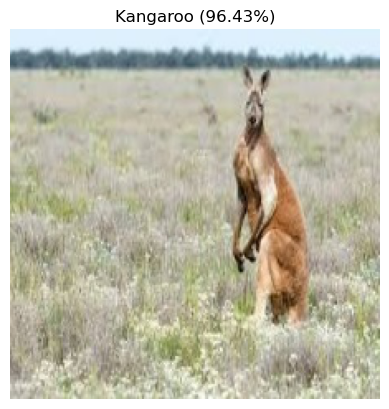

In [58]:
image_path = "C:/Users/LATHA M/OneDrive/Desktop/Animal Classification/dataset/Kangaroo/Kangaroo_18_1.jpg"
classify_image(image_path)
